In [33]:
# Import packages
%reset -f
from helpers import load_all_data, vectorized_flatten, sigmoid, get_log_loss, get_accuracy, sigmoid_derivative, gradient_update, get_loss_plot, plot_loss
import numpy as np
import cv2

In [34]:
def prep_data(data_path):
    '''
    --------------------
    Prepare data
    Use vectorized flatten
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    # Load
    X_train, y_train, X_dev, y_dev, X_test, y_test = load_all_data(data_path)
    
    # Flatten
    X_train_flattened = vectorized_flatten(X_train)
    X_dev_flattened = vectorized_flatten(X_dev)
    X_test_flattened = vectorized_flatten(X_test)
    
    # Reshape labels
    y_train = y_train.reshape(1, -1)
    y_dev = y_dev.reshape(1, -1)
    y_test = y_test.reshape(1, -1)
    
    # Return
    return(X_train_flattened, X_dev_flattened, X_test_flattened, y_train, y_dev, y_test)

In [35]:
def initialize(X): 
    '''
    --------------------
    Parameter Initialization
    --------------------
    Parameters: 
    X: Numpy array of training features (shape = 784 X [n = 12000])
    --------------------
    Output: 
    weights: Weight terms initialized as random normals
    biases: Bias terms initialized to zero
    --------------------
    '''
    dim1 = 1/np.sqrt(X.shape[0])
    W1 = dim1 * np.random.randn(h1, 28**2)
    
    dim2 = 1/np.sqrt(W1.shape[1])
    W2 = dim2 * np.random.randn(h2, h1)
    
    dim3 = 1/np.sqrt(W2.shape[1])
    W3 = dim3 * np.random.randn(1, h2)

    b1 = np.zeros((h1, 1))
    b2 = np.zeros((h2, 1))
    b3 = np.zeros((1, 1))
    
    weights = (W1, W2, W3)
    biases = (b1, b2, b3)
    
    return weights, biases

In [36]:
def forward_pass(X, weights, biases):
    '''
    ----------------------------------
    Forward propogation:
    Send inputs through the network to
    generate output
    ----------------------------------
    Parameters: 
    X: Numpy array of training features (shape = 784 X n)
    weights: Binary (1/0) training label (shape = n X 1)
    biases:
    --------------------
    Output: 
    activations: vector of results from passing
    inputs through each neuron
    --------------------
    '''
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    
    z1 = W1 @ X + b1
    a1 = sigmoid(z1)
    
    z2 = W2 @ a1 + b2
    a2 = sigmoid(z2)
    
    z3 = W3 @ a2 + b3
    a3 = sigmoid(z3)
    
    activations = (z1, a1, z2, a2, z3, a3)
    
    return activations

In [37]:
def backpropagation(X, y, weights, biases, activations):
    '''
    --------------------
    Backpropagation
    --------------------
    Parameters: 
    X: Numpy array of training features (shape = 784 X n)
    y: Binary (1/0) training label (shape = n X 1)
    weights: Current set of weights
    biases: Current set of biases
    activations: Current set of activations
    --------------------
    Output: 
    Derivatives required
    for optimization update
    --------------------
    '''
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    z1, a1, z2, a2, z3, a3 = activations
    m = max(y.shape)
    # print(m)
    
    dz3 = (a3 - y)/m
    # print("dz3", dz3.shape)
    
    dW3 = np.dot(dz3, a2.T)
    # print("dW3", dW3.shape)
    
    db3 = np.sum(dz3, axis=1).reshape(-1, 1)
    # print("db3", db3.shape)
    
    da2 = np.dot(W3.T, dz3)
    # print("da2", da2.shape)
    
    dz2 = da2 * sigmoid_derivative(z2)
    # print("dz2", dz2.shape)
    
    dW2 = np.dot(dz2, a1.T)
    # print("dW2", dW2.shape)
    
    db2 = np.sum(dz2, axis=1).reshape(-1, 1)
    # print("db2", db2.shape)
    
    da1 = np.dot(W2.T, dz2)
    # print("da1", da1.shape)
    
    dz1 = da1 * sigmoid_derivative(z1)
    # print("dz1", dz1.shape)
    
    dW1 = np.dot(dz1, X.T)
    # print("dW1", dW1.shape)
    
    db1 = np.sum(dz1, axis=1).reshape(-1, 1)
    # print("db1", db1.shape)
    
    return db1, dW1, db2, dW2, db3, dW3

In [38]:
def update_parameters(weights, biases, gradients, learning_rate):
    '''
    --------------------
    Update parameters
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    
    db1, dW1, db2, dW2, db3, dW3 = gradients
    
    W1 = gradient_update(W1, learning_rate, dW1)
    W2 = gradient_update(W2, learning_rate, dW2)
    W3 = gradient_update(W3, learning_rate, dW3)
   
    b1 = gradient_update(b1, learning_rate, db1)
    b2 = gradient_update(b2, learning_rate, db2)
    b3 = gradient_update(b3, learning_rate, db3)
    
    weights = (W1, W2, W3)
    biases = (b1, b2, b3)
    
    return weights, biases

In [39]:
def finite_differences(example, truth, weights, biases, delta_h=1e-9):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    
    I, J = W3.shape # Change here
    
    deltaW = np.zeros((I, J))
    
    activations = forward_pass(example, weights, biases)
    db1, dW1, db2, dW2, db3, dW3 = backpropagation(example, truth, weights, biases, activations)
    
    for i in range(I):
        for j in range(J):
    
            W_plus = np.copy(W3) # Change here
            W_minus = np.copy(W3) # Change here
            
            W_plus[i][j] += delta_h
            W_minus[i][j] -= delta_h
            
            weights_plus = [W1, W2, W_plus] # Change here
            weights_minus = [W1, W2, W_minus] # Change here
            
            activations_plus = forward_pass(example, weights_plus, biases)
            activations_minus = forward_pass(example, weights_minus, biases)

            loss_plus = get_log_loss(truth, activations_plus[-1])
            loss_minus =  get_log_loss(truth, activations_minus[-1])

            deltaW[i][j] = (loss_plus - loss_minus)/(2 * delta_h)

    difference = np.linalg.norm(dW3 - deltaW) # Change here
    
    return dW3, deltaW, difference, activations_plus[-1], activations_minus[-1] # Change here

In [40]:
def run_finite_differences(X_train_flattened, y_train, w, b, idx=10):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    dW, deltaW, difference, activations_plus, activations_minus = finite_differences(X_train_flattened[:, idx].reshape(-1, 1), 
                                                                  y_train[:, idx].reshape(-1, 1), w, b)
    
    print("dW", dW)
    print("deltaW", deltaW)
    print("difference", difference)
    print(activations_plus, activations_minus)
    
    return(dW, deltaW, difference, activations_plus, activations_minus)

In [41]:
def get_best_results(history):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    # Store results
    best_epoch = np.array(history["losses"]).argmin()
    best_accuracy = history['accuracies'][best_epoch]
    best_loss = history['losses'][best_epoch]
    
    # Display results
    print(f"best accuracy: {history['accuracies'][best_epoch]}")
    print(f"best loss: {history['losses'][best_epoch]}")
    print(f"best epoch: {best_epoch}")
    
    return(best_epoch, best_accuracy, best_loss)

In [42]:
def train(X, y, w, b, h1, h2, lr, epochs, tolerance=1e-1):    
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    # Initialize history dictionary
    history = {
        "weights": [w],
        "losses": [], 
        "biases": [b],
        "accuracies": []
    }
    
    convergence_counter = 0
    best_loss = np.inf
    
    # Do this for the specified epochs
    for epoch in range(epochs):
        
        # Get weights and bias
        w = history['weights'][epoch]
        b = history['biases'][epoch]
        
        # Forward pass to get activations
        activations = forward_pass(X, w, b)
        
        # Backward pass to get gradients
        gradients = backpropagation(X, y, w, b, activations)
        
        # Gradient descent update
        w, b = update_parameters(w, b, gradients, lr)
    
        # Get last layer output
        y_prob = activations[-1]
        
        # Threshold
        y_pred = np.where(y_prob > 0.5, 1, 0)
    
        # Get loss and accuracy results
        loss = get_log_loss(y, y_prob)
        accuracy = get_accuracy(y, y_pred)
        
        # Check convergence, keeps a counter of how many epochs it has been without an improvement
        # Counter resets whenever there's an improvent            
        if loss < best_loss - tolerance:
            best_loss = loss
            convergence_counter = 0
        else:
            convergence_counter += 1

        # Append results to history
        history["losses"].append(loss)
        history["biases"].append(b)
        history["weights"].append(w)
        history["accuracies"].append(accuracy)
        
        # 10 epochs without an improvment is considered to have converged
        if convergence_counter == 10:
            break
        
        # Display loss for monitoring
        print(loss)
        
        # Stop training if numerical loss underflows
        if np.isnan(loss): break
        
        # Store loss for next epoch
        previous_accuracy = accuracy
    
    # Return statement
    return(history)

In [43]:
def get_results(X_dev, y_dev, history, best_epoch, label="dev"):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    w = history["weights"][best_epoch]
    b = history["biases"][best_epoch]
    activations = forward_pass(X_dev, w, b)

    y_dev_prob = activations[-1]
    y_dev_pred = np.where(y_dev_prob > 0.5, 1, 0)

    loss = get_log_loss(y_dev, y_dev_prob)
    accuracy = get_accuracy(y_dev, y_dev_pred)
    print(f"{label} set accuracy: {accuracy}")
    
    return(accuracy)

In [44]:
def execute_pipeline(data_path, idx, h1, h2, lr, epochs):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    # Set seed for reproducible results
    np.random.seed(1252908)

    # Get data
    X_train_flattened, X_dev_flattened, X_test_flattened, y_train, y_dev, y_test = prep_data(data_path)

    # Initialize weights
    weights, biases = initialize(X_train_flattened)
    
    # Check finite difference
    dW, deltaW, difference, activations_plus, activations_minus = run_finite_differences(X_train_flattened, y_train, weights, biases, idx=10)
    
    # Now enter training loop
    training_history = train(X_train_flattened, y_train, weights, biases, h1, h2, lr, epochs)
    
    # Display plots to monitor whether loss functions are correct shape
    plot_loss("loss.png", training_history["losses"][:-2])
    
    # Plot accuracy
    plot_loss("accuracy.png", training_history["accuracies"][:-2], label='Training Accuracy')
    
    # Get weights and biases from best training epoch
    best_training_epoch, best_training_accuracy, best_training_loss = get_best_results(training_history)
    
    # Get dev results
    get_results(X_dev_flattened, y_dev, training_history, best_training_epoch)
    
    # Get test results
    get_results(X_test_flattened, y_test, training_history, best_training_epoch, label="test")
    
    return 

In [45]:
# Set path to data
data_path = '../setup/data'

In [46]:
# Set no. of observations to use for checking finite differences
idx = 10

In [47]:
# Set perceptron parameters: architecture, learning rate, and no. of training epochs
h1 = 8
h2 = 4
lr = 0.1
epochs = 1000

dW [[-0.18303023 -0.17351476 -0.17373708 -0.1751518 ]]
deltaW [[-0.1830302  -0.17351479 -0.17373697 -0.1751517 ]]
difference 1.5587573833456522e-07
[[0.64527729]] [[0.64527729]]
8856.98510033028 8856.98510033028
8804.025224598206 8804.025224598206
8756.259330743445 8756.259330743445
8713.189539991632 8713.189539991632
8674.362979977468 8674.362979977468
8639.368290840051 8639.368290840051
8607.832282727755 8607.832282727755
8579.416765249127 8579.416765249127
8553.81556174796 8553.81556174796
8530.751715035882 8530.751715035882
8509.974886243115 8509.974886243115
8491.258944588493 8491.258944588493
8474.39974296122 8474.39974296122
8459.213072094506 8459.213072094506
8445.532784652509 8445.532784652509
8433.209079621134 8433.209079621134
8422.10693687984 8422.10693687984
8412.104691643206 8412.104691643206
8403.092738519073 8403.092738519073
8394.972355171076 8394.972355171076
8387.654635945051 8387.654635945051
8381.059526279885 8381.059526279885
8375.114949240951 8375.114949240951
83

8306.115445905149 8306.115445905149
8306.000145242007 8306.000145242007
8305.884068093223 8305.884068093223
8305.767207175008 8305.767207175008
8305.649555150405 8305.649555150405
8305.53110462863 8305.53110462863
8305.411848164438 8305.411848164438
8305.291778257462 8305.291778257462
8305.170887351565 8305.170887351565
8305.04916783415 8305.04916783415
8304.926612035484 8304.926612035484
8304.80321222802 8304.80321222802
8304.678960625666 8304.678960625666
8304.553849383094 8304.553849383094
8304.427870595006 8304.427870595006
8304.301016295401 8304.301016295401
8304.17327845683 8304.17327845683
8304.044648989628 8304.044648989628
8303.915119741163 8303.915119741163
8303.78468249504 8303.78468249504
8303.653328970311 8303.653328970311
8303.521050820676 8303.521050820676
8303.387839633664 8303.387839633664
8303.253686929791 8303.253686929791
8303.11858416174 8303.11858416174
8302.982522713484 8302.982522713484
8302.845493899427 8302.845493899427
8302.707488963524 8302.707488963524
8302

8223.366377220847 8223.366377220847
8222.524170884695 8222.524170884695
8221.67360056924 8221.67360056924
8220.81457192286 8220.81457192286
8219.946989490096 8219.946989490096
8219.070756699308 8219.070756699308
8218.185775850177 8218.185775850177
8217.291948101083 8217.291948101083
8216.389173456324 8216.389173456324
8215.477350753223 8215.477350753223
8214.556377649065 8214.556377649065
8213.62615060791 8213.62615060791
8212.686564887244 8212.686564887244
8211.73751452451 8211.73751452451
8210.778892323462 8210.778892323462
8209.810589840406 8209.810589840406
8208.832497370257 8208.832497370257
8207.844503932482 8207.844503932482
8206.84649725687 8206.84649725687
8205.83836376917 8205.83836376917
8204.819988576557 8204.819988576557
8203.79125545298 8203.79125545298
8202.75204682433 8202.75204682433
8201.702243753476 8201.702243753476
8200.641725925148 8200.641725925148
8199.570371630669 8199.570371630669
8198.48805775254 8198.48805775254
8197.394659748876 8197.394659748876
8196.29005

7323.740682781289 7323.740682781289
7314.377085469282 7314.377085469282
7304.946328773102 7304.946328773102
7295.448393958324 7295.448393958324
7285.883268816868 7285.883268816868
7276.250947601771 7276.250947601771
7266.551430956268 7266.551430956268
7256.78472583718 7256.78472583718
7246.950845432722 7246.950845432722
7237.049809074775 7237.049809074775
7227.081642145702 7227.081642145702
7217.04637597984 7217.04637597984
7206.94404775976 7206.94404775976
7196.774700407436 7196.774700407436
7186.538382470472 7186.538382470472
7176.2351480035295 7176.2351480035295
7165.865056445175 7165.865056445175
7155.428172490279 7155.428172490279
7144.924565958251 7144.924565958251
7134.354311657247 7134.354311657247
7123.71748924467 7123.71748924467
7113.014183084172 7113.014183084172
7102.244482099444 7102.244482099444
7091.408479625072 7091.408479625072
7080.506273254783 7080.506273254783
7069.537964687383 7069.537964687383
7058.5036595707115 7058.5036595707115
7047.403467344004 7047.403467344

3959.8012113891464 3959.8012113891464
3946.0529973605862 3946.0529973605862
3932.3702428951738 3932.3702428951738
3918.753095887959 3918.753095887959
3905.201691411068 3905.201691411068
3891.716151960806 3891.716151960806
3878.296587703686 3878.296587703686
3864.943096721205 3864.943096721205
3851.6557652532333 3851.6557652532333
3838.4346679398423 3838.4346679398423
3825.2798680614687 3825.2798680614687
3812.1914177772587 3812.1914177772587
3799.1693583615047 3799.1693583615047
3786.2137204380538 3786.2137204380538
3773.3245242125877 3773.3245242125877
3760.5017797027012 3760.5017797027012
3747.745486965682 3747.745486965682
3735.0556363239275 3735.0556363239275
3722.4322085879244 3722.4322085879244
3709.8751752767394 3709.8751752767394
3697.3844988359588 3697.3844988359588
3684.9601328530343 3684.9601328530343
3672.602022269988 3672.602022269988
3660.310103593443 3660.310103593443
3648.084305101942 3648.084305101942
3635.9245470505316 3635.9245470505316
3623.8307418725835 3623.830741

2215.642904666529 2215.642904666529
2211.9952956137795 2211.9952956137795
2208.3679532433093 2208.3679532433093
2204.760736337713 2204.760736337713
2201.1735047249285 2201.1735047249285
2197.606119271691 2197.606119271691
2194.0584418769804 2194.0584418769804
2190.530335465469 2190.530335465469
2187.0216639809605 2187.0216639809605
2183.532292379841 2183.532292379841
2180.0620866245163 2180.0620866245163
2176.6109136768646 2176.6109136768646
2173.178641491688 2173.178641491688
2169.765139010165 2169.765139010165
2166.3702761533186 2166.3702761533186
2162.9939238154816 2162.9939238154816
2159.635953857781 2159.635953857781
2156.29623910162 2156.29623910162
2152.9746533221837 2152.9746533221837
2149.6710712419463 2149.6710712419463
2146.385368524197 2146.385368524197
2143.117421766575 2143.117421766575
2139.8671084946245 2139.8671084946245
2136.6343071553615 2136.6343071553615
2133.418897110858 2133.418897110858
2130.220758631843 2130.220758631843
2127.039772891322 2127.039772891322
2123

1715.292271943631 1715.292271943631
1714.0453925122301 1714.0453925122301
1712.803199197728 1712.803199197728
1711.5656658454163 1711.5656658454163
1710.3327664755664 1710.3327664755664
1709.1044752821056 1709.1044752821056
1707.8807666312987 1707.8807666312987
1706.661615060449 1706.661615060449
1705.4469952766037 1705.4469952766037
1704.2368821552698 1704.2368821552698
1703.0312507391466 1703.0312507391466
1701.8300762368613 1701.8300762368613
1700.6333340217207 1700.6333340217207
1699.4409996304703 1699.4409996304703
1698.2530487620634 1698.2530487620634
1697.069457276444 1697.069457276444
1695.8902011933337 1695.8902011933337
1694.7152566910336 1694.7152566910336
1693.544600105235 1693.544600105235
1692.378207927838 1692.378207927838
1691.2160568057827 1691.2160568057827
1690.0581235398859 1690.0581235398859
1688.9043850836927 1688.9043850836927
1687.7548185423323 1687.7548185423323
1686.6094011713872 1686.6094011713872
1685.468110375769 1685.468110375769
1684.330923708605 1684.330

1516.7604427803935 1516.7604427803935
1516.1381629459229 1516.1381629459229
1515.5174147377224 1515.5174147377224
1514.8981914915266 1514.8981914915266
1514.2804865788557 1514.2804865788557
1513.6642934067822 1513.6642934067822
1513.0496054177029 1513.0496054177029
1512.436416089111 1512.436416089111
1511.8247189333697 1511.8247189333697
1511.2145074974883 1511.2145074974883
1510.6057753628995 1510.6057753628995
1509.9985161452382 1509.9985161452382
1509.3927234941216 1509.3927234941216
1508.7883910929313 1508.7883910929313
1508.1855126585976 1508.1855126585976
1507.5840819413834 1507.5840819413834
1506.9840927246714 1506.9840927246714
1506.385538824753 1506.385538824753
1505.7884140906172 1505.7884140906172
1505.1927124037409 1505.1927124037409
1504.5984276778836 1504.5984276778836
1504.0055538588804 1504.0055538588804
1503.4140849244377 1503.4140849244377
1502.82401488393 1502.82401488393
1502.235337778199 1502.235337778199
1501.648047679353 1501.648047679353
1501.0621386905696 1501.

1408.1381210554612 1408.1381210554612
1407.737640050836 1407.737640050836
1407.3378020872665 1407.3378020872665
1406.93860482045 1406.93860482045
1406.5400459159468 1406.5400459159468
1406.1421230491287 1406.1421230491287
1405.7448339051286 1405.7448339051286
1405.3481761787903 1405.3481761787903
1404.9521475746187 1404.9521475746187
1404.5567458067317 1404.5567458067317
1404.1619685988085 1404.1619685988085
1403.7678136840427 1403.7678136840427
1403.374278805094 1403.374278805094
1402.981361714039 1402.981361714039
1402.589060172324 1402.589060172324
1402.197371950718 1402.197371950718
1401.806294829264 1401.806294829264
1401.4158265972342 1401.4158265972342
1401.0259650530818 1401.0259650530818
1400.636708004396 1400.636708004396
1400.248053267855 1400.248053267855
1399.8599986691816 1399.8599986691816
1399.472542043097 1399.472542043097
1399.0856812332759 1399.0856812332759
1398.6994140923023 1398.6994140923023
1398.313738481625 1398.313738481625
1397.9286522715138 1397.928652271513

1332.1887723017169 1332.1887723017169
1331.8868383288304 1331.8868383288304
1331.5852048634288 1331.5852048634288
1331.283870928866 1331.283870928866
1330.9828355523355 1330.9828355523355
1330.6820977648538 1330.6820977648538
1330.3816566012467 1330.3816566012467
1330.081511100137 1330.081511100137
1329.7816603039287 1329.7816603039287
1329.4821032587931 1329.4821032587931
1329.182839014657 1329.182839014657
1328.883866625186 1328.883866625186
1328.585185147773 1328.585185147773
1328.286793643524 1328.286793643524
1327.9886911772437 1327.9886911772437
1327.6908768174226 1327.6908768174226
1327.3933496362233 1327.3933496362233
1327.0961087094677 1327.0961087094677
1326.7991531166222 1326.7991531166222
1326.5024819407859 1326.5024819407859
1326.2060942686755 1326.2060942686755
1325.9099891906144 1325.9099891906144
1325.6141658005172 1325.6141658005172
1325.3186231958782 1325.3186231958782
1325.0233604777573 1325.0233604777573
1324.7283767507674 1324.7283767507674
1324.4336711230612 1324.

1270.5924988197212 1270.5924988197212
1270.3393535788086 1270.3393535788086
1270.0863646213315 1270.0863646213315
1269.833531561102 1269.833531561102
1269.5808540136704 1269.5808540136704
1269.328331596319 1269.328331596319
1269.0759639280566 1269.0759639280566
1268.8237506296123 1268.8237506296123
1268.5716913234307 1268.5716913234307
1268.3197856336662 1268.3197856336662
1268.0680331861768 1268.0680331861768
1267.8164336085192 1267.8164336085192
1267.5649865299438 1267.5649865299438
1267.313691581387 1267.313691581387
1267.0625483954689 1267.0625483954689
1266.811556606485 1266.811556606485
1266.5607158504033 1266.5607158504033
1266.3100257648564 1266.3100257648564
1266.059485989138 1266.059485989138
1265.8090961641972 1265.8090961641972
1265.558855932632 1265.558855932632
1265.3087649386853 1265.3087649386853
1265.0588228282397 1265.0588228282397
1264.8090292488112 1264.8090292488112
1264.5593838495442 1264.5593838495442
1264.3098862812067 1264.3098862812067
1264.0605361961852 1264.

1216.108080138033 1216.108080138033
1215.8835252564268 1215.8835252564268
1215.6590740967085 1215.6590740967085
1215.434726549327 1215.434726549327
1215.210482505454 1215.210482505454
1214.9863418569805 1214.9863418569805
1214.7623044965126 1214.7623044965126
1214.5383703173675 1214.5383703173675
1214.3145392135684 1214.3145392135684
1214.090811079842 1214.090811079842
1213.8671858116131 1213.8671858116131
1213.6436633050007 1213.6436633050007
1213.4202434568144 1213.4202434568144
1213.1969261645504 1213.1969261645504
1212.9737113263864 1212.9737113263864
1212.750598841179 1212.750598841179
1212.5275886084573 1212.5275886084573
1212.3046805284216 1212.3046805284216
1212.0818745019376 1212.0818745019376
1211.8591704305322 1211.8591704305322
1211.6365682163905 1211.6365682163905
1211.4140677623507 1211.4140677623507
1211.1916689719005 1211.1916689719005
1210.9693717491732 1210.9693717491732
1210.7471759989426 1210.7471759989426
1210.5250816266212 1210.5250816266212
1210.3030885382527 121

1165.8205436109956 1165.8205436109956
1165.6185071992763 1165.6185071992763
1165.4165606080019 1165.4165606080019
1165.214703800441 1165.214703800441
1165.0129367398704 1165.0129367398704
1164.811259389574 1164.811259389574
1164.6096717128403 1164.6096717128403
1164.4081736729624 1164.4081736729624
1164.2067652332362 1164.2067652332362
1164.0054463569588 1164.0054463569588
1163.8042170074277 1163.8042170074277
1163.603077147939 1163.603077147939
1163.402026741788 1163.402026741788
1163.2010657522642 1163.2010657522642
1163.000194142654 1163.000194142654
1162.7994118762383 1162.7994118762383
1162.5987189162893 1162.5987189162893
1162.3981152260726 1162.3981152260726
1162.1976007688436 1162.1976007688436
1161.997175507847 1161.997175507847
1161.7968394063168 1161.7968394063168
1161.5965924274733 1161.5965924274733
1161.396434534524 1161.396434534524
1161.1963656906603 1161.1963656906603
1160.9963858590581 1160.9963858590581
1160.7964950028768 1160.7964950028768
1160.596693085257 1160.596

1122.7367035075085 1122.7367035075085
1122.5538017972692 1122.5538017972692
1122.3709805814665 1122.3709805814665
1122.1882398115313 1122.1882398115313
1122.0055794388395 1122.0055794388395
1121.8229994147105 1121.8229994147105
1121.6404996904084 1121.6404996904084
1121.4580802171422 1121.4580802171422
1121.2757409460655 1121.2757409460655
1121.0934818282774 1121.0934818282774
1120.9113028148224 1120.9113028148224
1120.7292038566907 1120.7292038566907
1120.547184904819 1120.547184904819
1120.3652459100892 1120.3652459100892
1120.183386823331 1120.183386823331
1120.00160759532 1120.00160759532
1119.8199081767787 1119.8199081767787
1119.638288518378 1119.638288518378
1119.4567485707357 1119.4567485707357
1119.275288284418 1119.275288284418
1119.0939076099378 1119.0939076099378
1118.912606497758 1118.912606497758
1118.7313848982892 1118.7313848982892
1118.5502427618917 1118.5502427618917
1118.3691800388747 1118.3691800388747
1118.1881966794963 1118.1881966794963
1118.0072926339653 1118.00

1084.3482180759506 1084.3482180759506
1084.1817830847247 1084.1817830847247
1084.0154170326264 1084.0154170326264
1083.8491198652819 1083.8491198652819
1083.6828915283186 1083.6828915283186
1083.5167319673644 1083.5167319673644
1083.3506411280484 1083.3506411280484
1083.1846189560013 1083.1846189560013
1083.018665396854 1083.018665396854
1082.8527803962406 1082.8527803962406
1082.6869638997966 1082.6869638997966
1082.5212158531585 1082.5212158531585
1082.3555362019672 1082.3555362019672
1082.1899248918635 1082.1899248918635
1082.0243818684926 1082.0243818684926
1081.8589070775017 1081.8589070775017
1081.6935004645416 1081.6935004645416
1081.5281619752654 1081.5281619752654
1081.3628915553302 1081.3628915553302
1081.1976891503969 1081.1976891503969
1081.0325547061293 1081.0325547061293
1080.867488168196 1080.867488168196
1080.702489482269 1080.702489482269
1080.5375585940249 1080.5375585940249
1080.3726954491447 1080.3726954491447
1080.2078999933142 1080.2078999933142
1080.0431721722239

1048.2321224912766 1048.2321224912766
1048.0799611620503 1048.0799611620503
1047.9278567529889 1047.9278567529889
1047.775809213676 1047.775809213676
1047.6238184937256 1047.6238184937256
1047.4718845427801 1047.4718845427801
1047.3200073105133 1047.3200073105133
1047.1681867466277 1047.1681867466277
1047.016422800857 1047.016422800857
1046.864715422964 1046.864715422964
1046.7130645627428 1046.7130645627428
1046.5614701700163 1046.5614701700163
1046.4099321946387 1046.4099321946387
1046.2584505864947 1046.2584505864947
1046.1070252954992 1046.1070252954992
1045.9556562715975 1045.9556562715975
1045.8043434647655 1045.8043434647655
1045.6530868250106 1045.6530868250106
1045.5018863023697 1045.5018863023697
1045.3507418469112 1045.3507418469112
1045.199653408735 1045.199653408735
1045.048620937971 1045.048620937971
1044.8976443847807 1044.8976443847807
1044.7467236993562 1044.7467236993562
1044.5958588319213 1044.5958588319213
1044.4450497327311 1044.4450497327311
1044.2942963520718 104

1016.1835145350387 1016.1835145350387
1016.0426724758412 1016.0426724758412
1015.9018771096264 1015.9018771096264
1015.7611283938163 1015.7611283938163
1015.6204262858739 1015.6204262858739
1015.4797707433012 1015.4797707433012
1015.3391617236405 1015.3391617236405
1015.1985991844737 1015.1985991844737
1015.0580830834231 1015.0580830834231
1014.9176133781507 1014.9176133781507
1014.7771900263587 1014.7771900263587
1014.636812985789 1014.636812985789
1014.4964822142239 1014.4964822142239
1014.3561976694857 1014.3561976694857
1014.2159593094365 1014.2159593094365
1014.0757670919784 1014.0757670919784
1013.9356209750545 1013.9356209750545
1013.7955209166469 1013.7955209166469
1013.6554668747782 1013.6554668747782
1013.5154588075115 1013.5154588075115
1013.3754966729502 1013.3754966729502
1013.235580429237 1013.235580429237
1013.0957100345552 1013.0957100345552
1012.9558854471288 1012.9558854471288
1012.8161066252218 1012.8161066252218
1012.6763735271379 1012.6763735271379
1012.53668611122

985.8579348547045 985.8579348547045
985.7265250257907 985.7265250257907
985.595153393509 985.595153393509
985.463819924216 985.463819924216
985.3325245843073 985.3325245843073
985.2012673402164 985.2012673402164
985.0700481584151 985.0700481584151
984.9388670054136 984.9388670054136
984.8077238477595 984.8077238477595
984.6766186520395 984.6766186520395
984.5455513848776 984.5455513848776
984.4145220129365 984.4145220129365
984.2835305029167 984.2835305029167
984.1525768215562 984.1525768215562
984.0216609356315 984.0216609356315
983.890782811957 983.890782811957
983.759942417385 983.759942417385
983.6291397188052 983.6291397188052
983.4983746831455 983.4983746831455
983.3676472773717 983.3676472773717
983.2369574684872 983.2369574684872
983.106305223533 983.106305223533
982.9756905095879 982.9756905095879
982.8451132937681 982.8451132937681
982.714573543228 982.714573543228
982.584071225159 982.584071225159
982.4536063067903 982.4536063067903
982.3231787553883 982.3231787553883
982.19

954.9741437080866 954.9741437080866
954.8511113552865 954.8511113552865
954.7281100543997 954.7281100543997
954.6051397798504 954.6051397798504
954.4822005060903 954.4822005060903
954.3592922075991 954.3592922075991
954.2364148588831 954.2364148588831
954.1135684344763 954.1135684344763
953.9907529089405 953.9907529089405
953.8679682568638 953.8679682568638
953.7452144528625 953.7452144528625
953.622491471579 953.622491471579
953.4997992876838 953.4997992876838
953.3771378758736 953.3771378758736
953.254507210873 953.254507210873
953.1319072674328 953.1319072674328
953.0093380203311 953.0093380203311
952.886799444373 952.886799444373
952.7642915143902 952.7642915143902
952.6418142052412 952.6418142052412
952.5193674918114 952.5193674918114
952.3969513490124 952.3969513490124
952.2745657517836 952.2745657517836
952.1522106750897 952.1522106750897
952.0298860939226 952.0298860939226
951.9075919833008 951.9075919833008
951.7853283182692 951.7853283182692
951.6630950738991 951.663095073899

926.7474683770404 926.7474683770404
926.6311091372035 926.6311091372035
926.5147755859357 926.5147755859357
926.3984677030566 926.3984677030566
926.2821854684048 926.2821854684048
926.1659288618382 926.1659288618382
926.0496978632341 926.0496978632341
925.9334924524886 925.9334924524886
925.8173126095173 925.8173126095173
925.701158314255 925.701158314255
925.5850295466548 925.5850295466548
925.4689262866901 925.4689262866901
925.3528485143523 925.3528485143523
925.2367962096522 925.2367962096522
925.12076935262 925.12076935262
925.0047679233041 925.0047679233041
924.888791901773 924.888791901773
924.7728412681129 924.7728412681129
924.6569160024295 924.6569160024295
924.5410160848478 924.5410160848478
924.4251414955113 924.4251414955113
924.3092922145822 924.3092922145822
924.1934682222419 924.1934682222419
924.0776694986907 924.0776694986907
923.9618960241471 923.9618960241471
923.8461477788492 923.8461477788492
923.7304247430533 923.7304247430533
923.6147268970346 923.6147268970346


899.9577011688409 899.9577011688409
899.8468842570142 899.8468842570142
899.7360887693073 899.7360887693073
899.625314689667 899.625314689667
899.5145620020566 899.5145620020566
899.4038306904548 899.4038306904548
899.2931207388581 899.2931207388581
899.1824321312774 899.1824321312774
899.0717648517418 899.0717648517418
898.9611188842952 898.9611188842952
898.8504942129985 898.8504942129985
898.7398908219282 898.7398908219282
898.6293086951775 898.6293086951775
898.5187478168559 898.5187478168559
898.408208171089 898.408208171089
898.2976897420182 898.2976897420182
898.1871925138014 898.1871925138014
898.0767164706131 898.0767164706131
897.9662615966431 897.9662615966431
897.8558278760983 897.8558278760983
897.7454152932007 897.7454152932007
897.6350238321895 897.6350238321895
897.5246534773196 897.5246534773196
897.4143042128619 897.4143042128619
897.3039760231035 897.3039760231035
897.1936688923478 897.1936688923478
897.0833828049142 897.0833828049142
896.9731177451381 896.9731177451

874.3662809526718 874.3662809526718
874.2601091005729 874.2601091005729
874.1539553157479 874.1539553157479
874.0478195857078 874.0478195857078
873.9417018979772 873.9417018979772
873.8356022400935 873.8356022400935
873.7295205996085 873.7295205996085
873.6234569640864 873.6234569640864
873.5174113211053 873.5174113211053
873.4113836582567 873.4113836582567
873.3053739631446 873.3053739631446
873.1993822233873 873.1993822233873
873.0934084266157 873.0934084266157
872.9874525604744 872.9874525604744
872.8815146126205 872.8815146126205
872.7755945707248 872.7755945707248
872.6696924224714 872.6696924224714
872.5638081555575 872.5638081555575
872.4579417576928 872.4579417576928
872.352093216601 872.352093216601
872.2462625200184 872.2462625200184
872.1404496556943 872.1404496556943
872.0346546113914 872.0346546113914
871.9288773748851 871.9288773748851
871.8231179339639 871.8231179339639
871.7173762764294 871.7173762764294
871.611652390096 871.611652390096
871.5059462627912 871.5059462627

849.0699966557138 849.0699966557138
848.9678762170724 848.9678762170724
848.8657711460545 848.8657711460545
848.7636814326435 848.7636814326435
848.6616070668292 848.6616070668292
848.5595480386074 848.5595480386074
848.4575043379793 848.4575043379793
848.3554759549536 848.3554759549536
848.2534628795433 848.2534628795433
848.1514651017688 848.1514651017688
848.0494826116553 848.0494826116553
847.9475153992345 847.9475153992345
847.8455634545439 847.8455634545439
847.7436267676262 847.7436267676262
847.6417053285311 847.6417053285311
847.5397991273123 847.5397991273123
847.437908154031 847.437908154031
847.3360323987529 847.3360323987529
847.2341718515493 847.2341718515493
847.1323265024977 847.1323265024977
847.0304963416805 847.0304963416805
846.9286813591862 846.9286813591862
846.8268815451082 846.8268815451082
846.7250968895454 846.7250968895454
846.6233273826026 846.6233273826026
846.5215730143893 846.5215730143893
846.4198337750206 846.4198337750206
846.3181096546168 846.31810965

825.0783505691116 825.0783505691116
824.9796268036109 825.0783505691116
824.8809161003063 824.8809161003063
824.782218449574 824.8809161003063
824.6835338417883 824.6835338417883
824.58486226732 824.6835338417883
824.4862037165389 824.4862037165389
824.3875581798104 824.4862037165389
824.2889256474994 824.2889256474994
824.1903061099662 824.2889256474994
824.0916995575702 824.0916995575702
823.993105980667 824.0916995575702
823.8945253696099 823.8945253696099
823.7959577147498 823.8945253696099
823.6974030064342 823.6974030064342
823.5988612350084 823.6974030064342
823.5003323908152 823.5003323908152
823.4018164641935 823.5003323908152
823.3033134454806 823.3033134454806
823.20482332501 823.3033134454806
823.1063460931133 823.1063460931133
823.0078817401183 823.1063460931133
822.9094302563501 822.9094302563501
822.8109916321312 822.9094302563501
822.7125658577809 822.7125658577809
822.6141529236154 822.7125658577809
822.5157528199481 822.5157528199481
822.4173655370893 822.515752819948

801.4493243303414 801.5451760797821
801.3534832031088 801.3534832031088
801.2576526874868 801.3534832031088
801.1618327728738 801.1618327728738
801.0660234486649 801.1618327728738
800.9702247042515 800.9702247042515
800.8744365290216 800.9702247042515
800.7786589123593 800.7786589123593
800.6828918436456 800.7786589123593
800.5871353122578 800.5871353122578
800.4913893075693 800.5871353122578
800.3956538189506 800.3956538189506
800.2999288357688 800.3956538189506
800.2042143473868 800.2042143473868
800.1085103431649 800.2042143473868
800.0128168124597 800.0128168124597
799.9171337446244 800.0128168124597
799.8214611290086 799.8214611290086
799.7257989549596 799.8214611290086
799.6301472118203 799.6301472118203
799.5345058889304 799.6301472118203
799.4388749756273 799.4388749756273
799.3432544612444 799.4388749756273
799.2476443351117 799.2476443351117
799.1520445865569 799.2476443351117
799.056455204904 799.056455204904
798.9608761794736 799.056455204904
798.865307499584 798.8653074995

779.1018562503651 779.1954992237559
779.0082213644841 779.0082213644841
778.9145945555971 779.0082213644841
778.8209758131935 778.8209758131935
778.7273651267681 778.8209758131935
778.6337624858211 778.6337624858211
778.5401678798588 778.6337624858211
778.4465812983923 778.4465812983923
778.3530027309394 778.4465812983923
778.2594321670224 778.2594321670224
778.1658695961706 778.2594321670224
778.0723150079182 778.0723150079182
777.9787683918055 778.0723150079182
777.8852297373786 777.8852297373786
777.7916990341901 777.8852297373786
777.6981762717975 777.6981762717975
777.6046614397653 777.6981762717975
777.5111545276637 777.5111545276637
777.4176555250689 777.5111545276637
777.3241644215639 777.3241644215639
777.2306812067364 777.3241644215639
777.137205870182 777.137205870182
777.0437384015022 777.137205870182
776.9502787903039 776.9502787903039
776.8568270262012 776.9502787903039
776.7633830988148 776.7633830988148
776.669946997771 776.7633830988148
776.5765187127038 776.5765187127

756.7462367659894 756.7462367659894
756.6542625101331 756.7462367659894
756.5622940421421 756.5622940421421
756.4703313537669 756.5622940421421
756.3783744367696 756.3783744367696
756.2864232829227 756.3783744367696
756.1944778840091 756.1944778840091
756.1025382318229 756.1944778840091
756.0106043181685 756.0106043181685
755.9186761348616 756.0106043181685
755.826753673728 755.826753673728
755.7348369266044 755.826753673728
755.6429258853384 755.6429258853384
755.5510205417876 755.6429258853384
755.4591208878207 755.4591208878207
755.3672269153169 755.4591208878207
755.2753386161658 755.2753386161658
755.1834559822679 755.2753386161658
755.0915790055337 755.0915790055337
754.9997076778851 755.0915790055337
754.9078419912531 754.9078419912531
754.8159819375803 754.9078419912531
754.7241275088195 754.7241275088195
754.6322786969338 754.7241275088195
754.5404354938967 754.5404354938967
754.4485978916917 754.5404354938967
754.3567658823138 754.3567658823138
754.264939457767 754.3567658823

734.7301067317078 734.8209082639726
734.639309235972 734.639309235972
734.5485157699358 734.639309235972
734.4577263267685 734.4577263267685
734.3669408996382 734.4577263267685
734.2761594817124 734.2761594817124
734.185382066157 734.2761594817124
734.0946086461366 734.0946086461366
734.003839214815 734.0946086461366
733.913073765354 733.913073765354
733.8223122909146 733.913073765354
733.731554784656 733.731554784656
733.640801239736 733.731554784656
733.5500516493105 733.5500516493105
733.4593060065342 733.5500516493105
733.3685643045599 733.3685643045599
733.2778265365381 733.3685643045599
733.1870926956187 733.1870926956187
733.0963627749484 733.1870926956187
733.0056367676729 733.0056367676729
732.914914666935 733.0056367676729
732.8241964658766 732.8241964658766
732.7334821576363 732.8241964658766
732.6427717353512 732.6427717353512
732.5520651921561 732.6427717353512
732.4613625211832 732.4613625211832
732.3706637155628 732.4613625211832
732.2799687684221 732.2799687684221
732.1

713.2183457360996 713.3083877938061
713.1283059624177 713.1283059624177
713.0382684646681 713.1283059624177
712.9482332347527 712.9482332347527
712.8582002645691 712.9482332347527
712.7681695460088 712.7681695460088
712.6781410709592 712.7681695460088
712.5881148313017 712.5881148313017
712.4980908189136 712.5881148313017
712.4080690256669 712.4080690256669
712.3180494434284 712.4080690256669
712.2280320640608 712.2280320640608
712.1380168794213 712.2280320640608
712.048003881363 712.048003881363
711.9579930617339 712.048003881363
711.8679844123774 711.8679844123774
711.7779779251329 711.8679844123774
711.6879735918344 711.6879735918344
711.5979714043125 711.6879735918344
711.5079713543926 711.5079713543926
711.4179734338961 711.5079713543926
711.3279776346398 711.3279776346398
711.237983948437 711.3279776346398
711.1479923670961 711.1479923670961
711.0580028824219 711.1479923670961
710.9680154862149 710.9680154862149
710.8780301702718 710.9680154862149
710.7880469263853 710.7880469263

692.1937837788691 692.2835137525356
692.1040542276828 692.1040542276828
692.0143250922174 692.1040542276828
691.924596365735 691.924596365735
691.8348680415196 691.924596365735
691.7451401128765 691.7451401128765
691.6554125731338 691.7451401128765
691.5656854156412 691.5656854156412
691.4759586337706 691.5656854156412
691.3862322209168 691.3862322209168
691.2965061704971 691.3862322209168
691.2067804759515 691.2067804759515
691.117055130743 691.2067804759515
691.0273301283578 691.0273301283578
690.9376054623056 691.0273301283578
690.8478811261191 690.8478811261191
690.758157113355 690.8478811261191
690.6684334175941 690.6684334175941
690.5787100324405 690.6684334175941
690.488986951523 690.488986951523
690.3992641684949 690.488986951523
690.309541677033 690.309541677033
690.2198194708401 690.309541677033
690.1300975436427 690.1300975436427
690.0403758891932 690.1300975436427
689.9506545012687 689.9506545012687
689.8609333736715 689.9506545012687
689.7712125002297 689.7712125002297
689

670.3900372634389 670.3900372634389
670.3002859687051 670.3900372634389
670.2105344908773 670.2105344908773
670.120782833408 670.2105344908773
670.0310309998096 670.0310309998096
669.9412789936544 670.0310309998096
669.8515268185752 669.8515268185752
669.7617744782656 669.8515268185752
669.6720219764795 669.6720219764795
669.5822693170314 669.6720219764795
669.4925165037971 669.4925165037971
669.4027635407124 669.4925165037971
669.3130104317745 669.3130104317745
669.2232571810421 669.3130104317745
669.1335037926345 669.1335037926345
669.0437502707325 669.1335037926345
668.9539966195784 668.9539966195784
668.8642428434761 668.9539966195784
668.7744889467906 668.7744889467906
668.6847349339488 668.7744889467906
668.5949808094394 668.5949808094394
668.5052265778135 668.5949808094394
668.4154722436832 668.4154722436832
668.3257178117234 668.4154722436832
668.2359632866708 668.2359632866708
668.1462086733246 668.2359632866708
668.0564539765464 668.0564539765464
667.9666992012596 668.0564539

648.6818079089105 648.6818079089105
648.592262366241 648.6818079089105
648.5027193525078 648.5027193525078
648.4131788866217 648.5027193525078
648.3236409875492 648.3236409875492
648.2341056743144 648.3236409875492
648.1445729659974 648.1445729659974
648.0550428817352 648.1445729659974
647.9655154407197 647.9655154407197
647.8759906622004 647.9655154407197
647.7864685654815 647.7864685654815
647.6969491699233 647.7864685654815
647.6074324949418 647.6074324949418
647.517918560008 647.6074324949418
647.4284073846484 647.4284073846484
647.3388989884445 647.4284073846484
647.2493933910328 647.2493933910328
647.1598906121039 647.2493933910328
647.070390671404 647.070390671404
646.9808935887327 647.070390671404
646.8913993839444 646.8913993839444
646.8019080769473 646.8913993839444
646.7124196877039 646.7124196877039
646.6229342362298 646.7124196877039
646.5334517425945 646.5334517425945
646.4439722269207 646.5334517425945
646.3544957093845 646.3544957093845
646.2650222102149 646.35449570938

628.1078905302272 628.1962648310715
628.019524197128 628.019524197128
627.931165858073 628.019524197128
627.8428155393649 627.8428155393649
627.7544732673077 627.8428155393649
627.6661390682088 627.6661390682088
627.5778129683771 627.6661390682088
627.489494994123 627.489494994123
627.4011851717585 627.489494994123
627.3128835275967 627.3128835275967
627.2245900879517 627.3128835275967
627.1363048791383 627.1363048791383
627.0480279274713 627.1363048791383
626.9597592592659 626.9597592592659
626.8714989008372 626.9597592592659
626.7832468784998 626.7832468784998
626.6950032185675 626.7832468784998
626.6067679473534 626.6067679473534
626.5185410911694 626.6067679473534
626.4303226763251 626.4303226763251
626.3421127291297 626.4303226763251
626.2539112758895 626.2539112758895
626.1657183429093 626.2539112758895
626.0775339564902 626.0775339564902
625.9893581429317 626.0775339564902
625.9011909285298 625.9011909285298
625.8130323395769 625.9011909285298
625.7248824023627 625.7248824023627

607.4450815429926 607.4450815429926
607.3593194689192 607.4450815429926
607.2735711721632 607.2735711721632
607.1878366733467 607.2735711721632
607.1021159930468 607.1021159930468
607.0164091517978 607.1021159930468
606.9307161700892 606.9307161700892
606.8450370683664 606.9307161700892
606.7593718670315 606.7593718670315
606.6737205864408 606.7593718670315
606.5880832469074 606.5880832469074
606.5024598686992 606.5880832469074
606.4168504720402 606.4168504720402
606.3312550771087 606.4168504720402
606.2456737040393 606.2456737040393
606.1601063729205 606.2456737040393
606.0745531037969 606.0745531037969
605.9890139166678 606.0745531037969
605.9034888314866 605.9034888314866
605.8179778681626 605.9034888314866
605.7324810465587 605.7324810465587
605.6469983864934 605.7324810465587
605.5615299077389 605.5615299077389
605.4760756300221 605.5615299077389
605.3906355730242 605.3906355730242
605.3052097563807 605.3906355730242
605.2197981996815 605.2197981996815
605.1344009224697 605.219798

587.5439155630684 587.625957044313
587.4618913938026 587.4618913938026
587.3798845456798 587.4618913938026
587.2978950278177 587.2978950278177
587.2159228492862 587.2978950278177
587.133968019108 587.133968019108
587.0520305462588 587.133968019108
586.9701104396671 586.9701104396671
586.8882077082142 586.9701104396671
586.8063223607346 586.8063223607346
586.7244544060159 586.8063223607346
586.6426038527984 586.6426038527984
586.5607707097759 586.6426038527984
586.4789549855954 586.4789549855954
586.3971566888565 586.4789549855954
586.315375828113 586.315375828113
586.2336124118717 586.315375828113
586.1518664485924 586.1518664485924
586.0701379466894 586.1518664485924
585.9884269145292 585.9884269145292
585.9067333604329 585.9884269145292
585.8250572926744 585.8250572926744
585.7433987194821 585.8250572926744
585.6617576490378 585.6617576490378
585.5801340894765 585.6617576490378
585.4985280488883 585.4985280488883
585.416939535316 585.4985280488883
585.3353685567572 585.3353685567572


568.2919388788245 568.2919388788245
568.214252424049 568.2919388788245
568.1365842695146 568.1365842695146
568.0589344149055 568.1365842695146
567.9813028598758 567.9813028598758
567.9036896040504 567.9813028598758
567.8260946470241 567.8260946470241
567.7485179883621 567.8260946470241
567.6709596276 567.6709596276
567.5934195642446 567.6709596276
567.515897797773 567.515897797773
567.4383943276326 567.515897797773
567.3609091532423 567.3609091532423
567.2834422739913 567.3609091532423
567.2059936892402 567.2059936892402
567.1285633983207 567.2059936892402
567.0511514005349 567.0511514005349
566.973757695157 567.0511514005349
566.8963822814319 566.8963822814319
566.819025158576 566.8963822814319
566.7416863257774 566.7416863257774
566.6643657821954 566.7416863257774
566.5870635269611 566.5870635269611
566.5097795591771 566.5870635269611
566.4325138779179 566.4325138779179
566.3552664822296 566.4325138779179
566.2780373711305 566.2780373711305
566.2008265436108 566.2780373711305
566.123

550.241169067792 550.3145652027691
550.1677904836871 550.1677904836871
550.094429445111 550.1677904836871
550.0210859467081 550.0210859467081
549.9477599831088 550.0210859467081
549.8744515489304 549.8744515489304
549.8011606387776 549.8744515489304
549.7278872472419 549.7278872472419
549.6546313689012 549.7278872472419
549.5813929983211 549.5813929983211
549.5081721300544 549.5813929983211
549.4349687586404 549.4349687586404
549.3617828786062 549.4349687586404
549.2886144844658 549.2886144844658
549.2154635707211 549.2886144844658
549.1423301318612 549.1423301318612
549.069214162362 549.1423301318612
548.9961156566878 548.9961156566878
548.9230346092899 548.9961156566878
548.8499710146073 548.8499710146073
548.7769248670672 548.8499710146073
548.7038961610835 548.7038961610835
548.630884891059 548.7038961610835
548.5578910513834 548.5578910513834
548.4849146364354 548.5578910513834
548.41195564058 548.41195564058
548.3390140581719 548.41195564058
548.2660898835528 548.2660898835528
54

533.3280063542359 533.3280063542359
533.2586138711849 533.3280063542359
533.1892374037536 533.1892374037536
533.1198769447856 533.1892374037536
533.0505324871208 533.0505324871208
532.9812040235968 533.0505324871208
532.9118915470483 532.9118915470483
532.842595050307 532.9118915470483
532.7733145262015 532.7733145262015
532.7040499675581 532.7733145262015
532.6348013672005 532.6348013672005
532.5655687179487 532.6348013672005
532.4963520126212 532.4963520126212
532.4271512440329 532.4963520126212
532.3579664049967 532.3579664049967
532.2887974883224 532.3579664049967
532.2196444868177 532.2196444868177
532.1505073932874 532.2196444868177
532.081386200534 532.081386200534
532.0122809013573 532.081386200534
531.9431914885548 531.9431914885548
531.874117954922 531.9431914885548
531.8050602932511 531.8050602932511
531.7360184963327 531.8050602932511
531.6669925569547 531.6669925569547
531.5979824679026 531.6669925569547
531.5289882219602 531.5289882219602
531.4600098119083 531.52898822196

516.9851367323693 516.9851367323693
516.9194082792458 516.9851367323693
516.853694085611 516.853694085611
516.7879941443224 516.853694085611
516.7223084482396 516.7223084482396
516.6566369902249 516.7223084482396
516.5909797631427 516.5909797631427
516.5253367598601 516.5909797631427
516.4597079732469 516.4597079732469
516.3940933961744 516.4597079732469
516.3284930215174 516.3284930215174
516.2629068421527 516.3284930215174
516.1973348509598 516.1973348509598
516.1317770408205 516.1973348509598
516.0662334046193 516.0662334046193
516.0007039352436 516.0662334046193
515.9351886255823 515.9351886255823
515.8696874685279 515.9351886255823
515.8042004569753 515.8042004569753
515.7387275838219 515.8042004569753
515.6732688419673 515.6732688419673
515.6078242243144 515.6732688419673
515.5423937237686 515.5423937237686
515.4769773332374 515.5423937237686
515.4115750456315 515.4115750456315
515.3461868538643 515.4115750456315
515.2808127508517 515.2808127508517
515.2154527295124 515.280812750

501.8535627271559 501.8535627271559
501.7910081495398 501.8535627271559
501.72846623715924 501.72846623715924
501.665936983734 501.72846623715924
501.6034203829888 501.6034203829888
501.54091642865274 501.6034203829888
501.47842511445907 501.47842511445907
501.4159464341464 501.47842511445907
501.35348038145736 501.35348038145736
501.29102695013967 501.35348038145736
501.22858613394453 501.22858613394453
501.16615792662935 501.22858613394453
501.10374232195454 501.10374232195454
501.04133931368625 501.10374232195454
500.97894889559467 500.97894889559467
500.9165710614547 500.97894889559467
500.85420580504604 500.85420580504604
500.7918531201526 500.85420580504604
500.7295130005632 500.7295130005632
500.66718544007153 500.7295130005632
500.6048704324753 500.6048704324753
500.54256797157734 500.6048704324753
500.4802780511851 500.4802780511851
500.41800066511 500.4802780511851
500.35573580716914 500.35573580716914
500.2934834711837 500.35573580716914
500.2312436509796 500.2312436509796
5

487.60815831419063 487.66793305475466
487.5483949107763 487.5483949107763
487.48864283936496 487.5483949107763
487.428902094815 487.428902094815
487.36917267198976 487.428902094815
487.30945456575773 487.30945456575773
487.24974777099203 487.30945456575773
487.1900522825715 487.1900522825715
487.1303680953792 487.1900522825715
487.0706952043039 487.0706952043039
487.0110336042387 487.0706952043039
486.9513832900823 486.9513832900823
486.89174425673826 486.9513832900823
486.83211649911476 486.83211649911476
486.77250001212525 486.83211649911476
486.71289479068884 486.71289479068884
486.65330082972844 486.71289479068884
486.5937181241727 486.5937181241727
486.53414666895503 486.5937181241727
486.4745864590143 486.4745864590143
486.4150374892937 486.4745864590143
486.3554997547419 486.3554997547419
486.2959732503125 486.3554997547419
486.23645797096407 486.23645797096407
486.1769539116598 486.23645797096407
486.11746106736894 486.11746106736894
486.057979433064 486.11746106736894
485.9985

473.92220874876915 473.979460466246
473.86496729808346 473.86496729808346
473.80773611017315 473.86496729808346
473.75051518102714 473.75051518102714
473.6933045066386 473.75051518102714
473.63610408300525 473.63610408300525
473.5789139061292 473.63610408300525
473.5217339720177 473.5217339720177
473.4645642766818 473.5217339720177
473.40740481613744 473.40740481613744
473.350255586405 473.40740481613744
473.29311658350946 473.29311658350946
473.23598780348027 473.29311658350946
473.17886924235086 473.17886924235086
473.12176089616014 473.17886924235086
473.0646627609508 473.0646627609508
473.00757483277016 473.0646627609508
472.9504971076701 472.9504971076701
472.8934295817069 472.9504971076701
472.83637225094196 472.83637225094196
472.7793251114397 472.83637225094196
472.7222881592704 472.7222881592704
472.6652613905083 472.7222881592704
472.60824480123193 472.60824480123193
472.5512383875247 472.60824480123193
472.494242145474 472.494242145474
472.437256071172 472.494242145474
472.3

461.1293973285627 461.18440370025564
461.074400418121 461.074400418121
461.01941296584914 461.074400418121
460.9644349686695 460.9644349686695
460.90946642350747 460.9644349686695
460.85450732729265 460.85450732729265
460.79955767695805 460.85450732729265
460.7446174694401 460.7446174694401
460.6896867016789 460.7446174694401
460.63476537061837 460.63476537061837
460.5798534732056 460.63476537061837
460.5249510063917 460.5249510063917
460.4700579671312 460.5249510063917
460.41517435238177 460.41517435238177
460.36030015910535 460.41517435238177
460.30543538426684 460.30543538426684
460.2505800248352 460.30543538426684
460.1957340777825 460.1957340777825
460.1408975400848 460.1957340777825
460.0860704087212 460.0860704087212
460.0312526806746 460.0860704087212
459.9764443529314 459.9764443529314
459.9216454224816 459.9764443529314
459.86685588631866 459.86685588631866
459.8120757414396 459.86685588631866
459.7573049848452 459.7573049848452
459.7025436135389 459.7573049848452
459.6477916

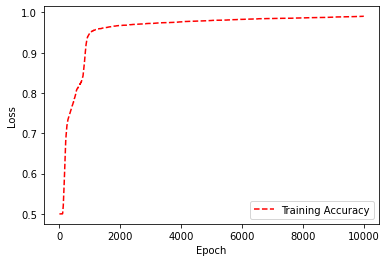

In [48]:
# Execute pipeline
execute_pipeline(data_path, idx, h1, h2, lr, epochs)